In [1]:
import sys
sys.path.append('/home/yunwei/SNAIL/SNAIL_new')

import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from helper.system import Hamiltonian

In [2]:
# ── System parameters (same as qenergy_vs_app.py) ──────────────────────────
Ej = 30.19
Ec = 0.1
omega_c1 = 5.226
omega_c2 = 8.135
phi_ex = 0.2
bare_dim = [10, 1, 6]
trunc_dim = [5, 1, 4]

sc = Hamiltonian(phi_ex, Ej, Ec, bare_dim, trunc_dim, omega_c1, omega_c2)

# Dressed SNAIL frequency (zero-drive reference for detuning)
position = sc.state_index((1, 0, 0), sc.original_dim)
omega_s = sc.H_dressed[position, position].real  # in angular frequency
print(f"Dressed SNAIL frequency: {omega_s / (2 * np.pi):.4f} GHz")

Dressed SNAIL frequency: 6.1591 GHz


In [4]:
# ── Sweep parameters ────────────────────────────────────────────────────────
N_det = 100
N_amp = 100
detu =2e-3
# Drive frequencies: linear from 6.17 to 6.2 GHz
omega_ds = np.linspace(6.159-detu, 6.159+0.025, N_det) * 2 * np.pi

# Drive amplitudes: linear from 2 to 15 mA (in angular freq units)
amplitudes = 2 * np.pi * np.linspace(0.01e-3, 10e-3, N_amp)
# ── Calculation ─────────────────────────────────────────────────────────────
def calculate_static_rate(omegad, amplitude):
    der = sc.equasi_gradient(amplitude, omegad)[0]
    return np.abs(der) / 2 / np.pi

print(f"Running 2D sweep: {N_amp} amplitudes x {N_det} detunings = {N_amp * N_det} points ...")

# Flatten the 2D grid for parallel computation
tasks = [(i_amp, i_det, omega_ds[i_det], amplitudes[i_amp])
         for i_amp in range(N_amp) for i_det in range(N_det)]

results = Parallel(n_jobs=-1, verbose=5)(
    delayed(calculate_static_rate)(omegad, amp)
    for (_, _, omegad, amp) in tasks
)

# Reshape into 2D array
rates = np.zeros((N_amp, N_det))
for idx, (i_amp, i_det, _, _) in enumerate(tasks):
    rates[i_amp, i_det] = results[idx]

Running 2D sweep: 100 amplitudes x 100 detunings = 10000 points ...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done 520 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done 754 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done 1024 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done 1330 tasks      | elapsed:   27.2s
[Parallel(n_jobs=-1)]: Done 1672 tasks      | elapsed:   31.5s
[Parallel(n_jobs=-1)]: Done 2050 tasks      | elapsed:   37.0s
[Parallel(n_jobs=-1)]: Done 2464 tasks      | elapsed:   43.3s
[Parallel(n_jobs=-1)]: Done 2914 tasks      | elapsed:   48.9s
[Parallel(n_jobs=-1)]: Done 3400 tasks      | elapsed:   56.0s
[Parallel(n_jobs=-1)]: Done 3922 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 4480 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 5074 tasks      | 

In [ ]:
# ── Sweep parameters ────────────────────────────────────────────────────────
N_det = 100
N_amp = 100
detu =2e-3
# Drive frequencies: linear from 6.17 to 6.2 GHz
omega_ds = np.linspace(6.159-detu, 6.159+detu, N_det) * 2 * np.pi

# Drive amplitudes: linear from 2 to 15 mA (in angular freq units)
amplitudes = 2 * np.pi * np.linspace(0.01e-3, 0.2e-3, N_amp)
# ── Calculation ─────────────────────────────────────────────────────────────
def calculate_static_rate(omegad, amplitude):
    der = sc.equasi_gradient(amplitude, omegad)[0]
    return np.abs(der) / 2 / np.pi

print(f"Running 2D sweep: {N_amp} amplitudes x {N_det} detunings = {N_amp * N_det} points ...")

# Flatten the 2D grid for parallel computation
tasks = [(i_amp, i_det, omega_ds[i_det], amplitudes[i_amp])
         for i_amp in range(N_amp) for i_det in range(N_det)]

results = Parallel(n_jobs=-1, verbose=5)(
    delayed(calculate_static_rate)(omegad, amp)
    for (_, _, omegad, amp) in tasks
)

# Reshape into 2D array
rates2 = np.zeros((N_amp, N_det))
for idx, (i_amp, i_det, _, _) in enumerate(tasks):
    rates2[i_amp, i_det] = results[idx]

Running 2D sweep: 100 amplitudes x 100 detunings = 10000 points ...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    4.7s


In [ ]:
import pickle

N_det = 100
N_amp = 100
detu = 2e-3

data = {
    'rates': rates,
    'rates_omega_ds': np.linspace(6.159 - detu, 6.159 + 0.025, N_det) * 2 * np.pi,
    'rates_amplitudes': 2 * np.pi * np.linspace(0.01e-3, 10e-3, N_amp),
    'rates2': rates2,
    'rates2_omega_ds': np.linspace(6.159 - detu, 6.159 + detu, N_det) * 2 * np.pi,
    'rates2_amplitudes': 2 * np.pi * np.linspace(0.01e-3, 0.2e-3, N_amp),
}

with open('qenergy_2d_sweep_data.pkl', 'wb') as f:
    pickle.dump(data, f)

print("Data saved to qenergy_2d_sweep_data.pkl")

 /tmp/ipykernel_1131490/1083174375.py: 47

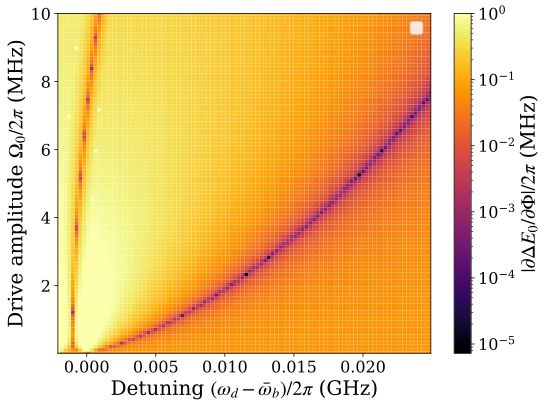

In [ ]:
# ── Plotting ────────────────────────────────────────────────────────────────
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Times New Roman', 'Times', 'DejaVu Serif'],
    'font.size': 16,
    'axes.titlesize': 16,
    'axes.labelsize': 20,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'legend.fontsize': 16,
    'figure.titlesize': 16,
    'mathtext.fontset': 'stix'
})

fig, ax = plt.subplots(figsize=(8, 6))

# Detuning in GHz for x-axis
detunings_ghz = omega_ds / (2 * np.pi) - omega_s / (2 * np.pi)
amps_mhz = amplitudes / (2 * np.pi) * 1e3

X, Y = np.meshgrid(detunings_ghz, amps_mhz)

# Handle bad values for LogNorm
rates_plot = np.copy(rates)
rates_plot[~np.isfinite(rates_plot) | (rates_plot <= 0)] = np.nan
vmin = np.nanmin(rates_plot)
vmax = np.nanmax(rates_plot)

cmap = plt.cm.inferno.copy()
cmap.set_bad(cmap(0))  # NaN pixels get the lowest color instead of white

pcm = ax.pcolormesh(
    X, Y, rates_plot,
    shading='nearest',
    norm=plt.matplotlib.colors.LogNorm(vmin=vmin, vmax=1),
    cmap=cmap,
)

# Analytical curves: delta = +/- 10 * Omega_0
analytic_det_ghz = 10 * amplitudes / (2 * np.pi)  # 10*Omega_0 in GHz

mask_pos = (analytic_det_ghz >= detunings_ghz[0]) & (analytic_det_ghz <= detunings_ghz[-1])
mask_neg = (-analytic_det_ghz >= detunings_ghz[0]) & (-analytic_det_ghz <= detunings_ghz[-1])

ax.set_xlim(detunings_ghz[0], detunings_ghz[-1])
ax.set_ylim(amps_mhz[0], amps_mhz[-1])
ax.legend()

ax.set_xlabel(r'Detuning $(\omega_d - \bar{\omega}_b)/2\pi$ (GHz)')
ax.set_ylabel(r'Drive amplitude $\Omega_0/2\pi$ (MHz)')

cbar = fig.colorbar(pcm, ax=ax, label=r'$|\partial \Delta E_0 / \partial \Phi|/2\pi$ (MHz)')

plt.tight_layout()
plt.savefig('qenergy_2d_sweep.pdf', bbox_inches='tight')
plt.show()

In [4]:
# ── Sweep parameters ────────────────────────────────────────────────────────
N_det = 100
N_amp = 100
detu =2e-3
# Drive frequencies: linear from 6.17 to 6.2 GHz
omega_ds = np.linspace(6.159-detu, 6.159+detu, N_det) * 2 * np.pi

# Drive amplitudes: linear from 2 to 15 mA (in angular freq units)
amplitudes = 2 * np.pi * np.linspace(0.01e-3, 0.1e-3, N_amp)
# ── Calculation ─────────────────────────────────────────────────────────────
def calculate_static_rate(omegad, amplitude):
    der = sc.equasi_gradient(amplitude, omegad)[0]
    return np.abs(der) / 2 / np.pi

print(f"Running 2D sweep: {N_amp} amplitudes x {N_det} detunings = {N_amp * N_det} points ...")

# Flatten the 2D grid for parallel computation
tasks = [(i_amp, i_det, omega_ds[i_det], amplitudes[i_amp])
         for i_amp in range(N_amp) for i_det in range(N_det)]

results = Parallel(n_jobs=-1, verbose=5)(
    delayed(calculate_static_rate)(omegad, amp)
    for (_, _, omegad, amp) in tasks
)

# Reshape into 2D array
rates2 = np.zeros((N_amp, N_det))
for idx, (i_amp, i_det, _, _) in enumerate(tasks):
    rates2[i_amp, i_det] = results[idx]

Running 2D sweep: 100 amplitudes x 100 detunings = 10000 points ...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 600 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done 834 tasks      | elapsed:   20.1s
[Parallel(n_jobs=-1)]: Done 1104 tasks      | elapsed:   25.5s
[Parallel(n_jobs=-1)]: Done 1410 tasks      | elapsed:   31.7s
[Parallel(n_jobs=-1)]: Done 1752 tasks      | elapsed:   38.5s
[Parallel(n_jobs=-1)]: Done 2130 tasks      | elapsed:   46.1s
[Parallel(n_jobs=-1)]: Done 2544 tasks      | elapsed:   54.3s
[Parallel(n_jobs=-1)]: Done 2994 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 3480 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 4002 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 4560 tasks      | e

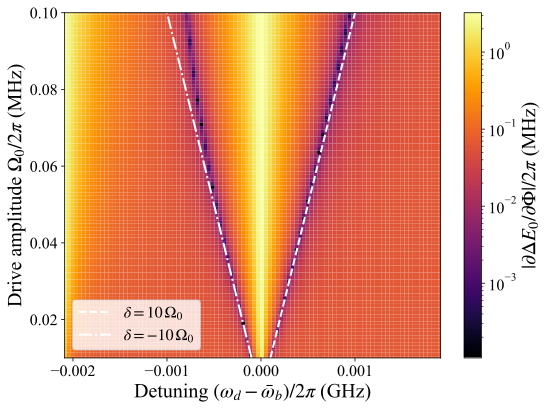

In [6]:
# ── Plotting ────────────────────────────────────────────────────────────────
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Times New Roman', 'Times', 'DejaVu Serif'],
    'font.size': 16,
    'axes.titlesize': 16,
    'axes.labelsize': 20,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'legend.fontsize': 16,
    'figure.titlesize': 16,
    'mathtext.fontset': 'stix'
})

fig, ax = plt.subplots(figsize=(8, 6))

# Detuning in GHz for x-axis
detunings_ghz = omega_ds / (2 * np.pi) - omega_s / (2 * np.pi)
amps_mhz = amplitudes / (2 * np.pi) * 1e3

X, Y = np.meshgrid(detunings_ghz, amps_mhz)

# Handle bad values for LogNorm
rates_plot = np.copy(rates2)
rates_plot[~np.isfinite(rates_plot) | (rates_plot <= 0)] = np.nan
vmin = np.nanmin(rates_plot)
vmax = np.nanmax(rates_plot)

cmap = plt.cm.inferno.copy()
cmap.set_bad(cmap(0))  # NaN pixels get the lowest color instead of white

pcm = ax.pcolormesh(
    X, Y, rates_plot,
    shading='nearest',
    norm=plt.matplotlib.colors.LogNorm(vmin=vmin, vmax=vmax),
    cmap=cmap,
)

# Analytical curves: delta = +/- 10 * Omega_0
analytic_det_ghz = 10 * amplitudes / (2 * np.pi)  # 10*Omega_0 in GHz

mask_pos = (analytic_det_ghz >= detunings_ghz[0]) & (analytic_det_ghz <= detunings_ghz[-1])
mask_neg = (-analytic_det_ghz >= detunings_ghz[0]) & (-analytic_det_ghz <= detunings_ghz[-1])
ax.plot(analytic_det_ghz[mask_pos], amps_mhz[mask_pos], 'w--', linewidth=2, label=r'$\delta = 10\,\Omega_0$')
if mask_neg.any():
    ax.plot(-analytic_det_ghz[mask_neg], amps_mhz[mask_neg], 'w-.', linewidth=2, label=r'$\delta = -10\,\Omega_0$')
ax.set_xlim(detunings_ghz[0], detunings_ghz[-1])
ax.set_ylim(amps_mhz[0], amps_mhz[-1])
ax.legend()

ax.set_xlabel(r'Detuning $(\omega_d - \bar{\omega}_b)/2\pi$ (GHz)')
ax.set_ylabel(r'Drive amplitude $\Omega_0/2\pi$ (MHz)')

cbar = fig.colorbar(pcm, ax=ax, label=r'$|\partial \Delta E_0 / \partial \Phi|/2\pi$ (MHz)')

plt.tight_layout()
plt.savefig('qenergy_2d_sweep.pdf', bbox_inches='tight')
plt.show()